In [1]:
from mongoconnection import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_csv('../data/cbd_info2.csv')

In [3]:
def lista ():
    a = dat.Effects.unique()
    b = [i.split(",") for i in a]
    z = []
    for j in b:
        for k in j:
            z.append(k)
            z = list(set(z))
            for x in z:
                if x == "None" or x=="Dry" or x=="Mouth":
                    z.remove(x)
    return z

In [4]:
filt = {"mood":{"$regex":"Happy"}}
project = {"mood":1, "product":1, "_id":0}
result = db.cbd_info.find(filt, project)
len(list(result))

1825

In [5]:
db.cbd_info.count({"mood": {"$regex": "Relaxed"}})

<ipython-input-5-b31db318e967>:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  db.cbd_info.count({"mood": {"$regex": "Relaxed"}})


1693

In [6]:
def check_exists(query, collection, *pro):
    res = read_coll(collection, query, pro)
    if len(res) > 0:
        return True
    else:
        return False

In [7]:
def convert(row):
    #print(row)
    return '<a href="{}">{}</a>'.format(row['shop'],  row.name)

In [238]:
def mood_description(moods):
    """
    This queries one collection to another and returns a DF with the 
    available CBD product given the mood chosen by user
    """
    filt = {"mood":{"$regex":f"{moods}"}}
    project = {"_id":0, "product":1, "description":1}
    result = db.cbd_info.find(filt, project)
   

    return list(result)

In [241]:
mood_description("Happy")[0]

{'product': '98-White Widow',
 'description': 'The ‘98 Aloha White Widow is an especially potent cut of White Widow that has grown in renown alongside Hawaiian legends like Maui Wowie and Kona Gold. This White Widow phenotype reeks of diesel and skunk and has a rich earthy taste with intermittent notes of hash. Its buds are coated in trichomes, giving its dark foliage a lustrous glint to go along with its room-filling odor. This one-hitter-quitter uplifts the mind with mind-bending euphoria that materializes in the body as airy relaxation. ‘98 Aloha White Widow is available from Pua Mana 1st Hawaiian Pakalōlō Seed Bank. \xa0'}

In [8]:
def shop_mood(moods):
    """
    This queries one collection to another and returns a DF with the 
    available CBD product given the mood chosen by user
    """
    
   #querying the KAGGLE dataset
    filt = {"mood":{"$regex":f"{moods}"}}
    project = {"_id":0, "product":1}
    result = db.cbd_info.find(filt, project)
    results= list(result)
    
    #querying the SCRAPPED dataset
    lista_res = []
    for i in results:
        q = {"product":i["product"]}
        pro = {"_id":0} 
        if check_exists(q, "cbd_shops"):
            lista_res.append(read_coll("cbd_shops",q,  pro))
            flat_list = [item for sublist in lista_res for item in sublist]
            df = pd.DataFrame(flat_list)
    

                    
    return flat_list


In [67]:
pd.DataFrame(shop_mood("Happy")).head()

,product,CBD percentage,price,shop
0,Cashmere Leaf,5%,"24,99 €",https://top-garden.net/es/flor-de-cbd/flor-de-...
1,Amnesia,4%,"13,50 €",https://top-garden.net/es/flor-de-cbd/flor-de-...
2,Amnesia,4%,"11,49 €",https://top-garden.net/es/flor-de-cbd/flor-de-...
3,Amnesia,6%,"10,99 €",https://top-garden.net/es/flor-de-cbd/flor-de-...
4,Bubblegum,4%,"13,50 €",https://top-garden.net/es/flor-de-cbd/flor-de-...


In [31]:
def mood_description(moods):
    """
    This queries one collection to another and returns a DF with the 
    available CBD product given the mood chosen by user
    """
    flat_list = shop_mood(moods)
    lista_description = []
    for shops in flat_list:
        qu = {"product":shops["product"]}
        pro = {"_id": 0, "product":1, "description":1}
        if check_exists(qu, "cbd_info"):
                    lista_description.append( read_coll("cbd_info",qu, pro))
                    flat_list2 = [item for sublist in lista_description for item in sublist]
                    df = pd.DataFrame(flat_list2)    

    return df

In [68]:
mood_description("Happy").head()

,product,description
0,Cashmere Leaf,"Also known as Optimus Prime, the indica-domina..."
1,Amnesia,Amnesia is typically a sativa-dominant cannabi...
2,Amnesia,Amnesia is typically a sativa-dominant cannabi...
3,Amnesia,Amnesia is typically a sativa-dominant cannabi...
4,Bubblegum,An 80% indica strain from Bulldog Seeds in the...


In [10]:
def shop_ratings(moods):
    flat_list = shop_mood(moods)
    lista_ratings = []
    for ratings in flat_list:
            qu= {"product":ratings["product"]}
            pro = {"_id":0}
            if check_exists(qu, "cbd_ratings"):
                        lista_ratings.append( read_coll("cbd_ratings",qu, pro))
                        flat_list2 = [item for sublist in lista_ratings for item in sublist]
                        ratings_df = pd.DataFrame(flat_list2)
                        rate_df = ratings_df.drop_duplicates(subset="product")
                            
    return rate_df

In [69]:
shop_ratings("Happy").head()

,product,rating
0,Cashmere Leaf,4.4
1,Amnesia,4.3
4,Bubblegum,4.3
5,Purple,4.3
6,Cannatonic,4.3


In [60]:
def merging_shop_rating(moods):
    """
    Esta funcion me devuelve un df de df shop_ratings + shoop_moods 
    """
    df1 = pd.DataFrame(shop_mood(moods))
    df2 = shop_ratings(moods)
    df3 = mood_description(moods)
    ttal = df1.merge(df2,on='product').merge(df3,on='product')
    df = ttal.drop_duplicates(subset=['product','price', 'CBD percentage'], keep='last')
    return df

In [70]:
merging_shop_rating("Happy").head()

,product,CBD percentage,price,shop,rating,description
0,Cashmere Leaf,5%,"24,99 €",https://top-garden.net/es/flor-de-cbd/flor-de-...,4.4,"Also known as Optimus Prime, the indica-domina..."
3,Amnesia,4%,"13,50 €",https://top-garden.net/es/flor-de-cbd/flor-de-...,4.3,Amnesia is typically a sativa-dominant cannabi...
6,Amnesia,4%,"11,49 €",https://top-garden.net/es/flor-de-cbd/flor-de-...,4.3,Amnesia is typically a sativa-dominant cannabi...
9,Amnesia,6%,"10,99 €",https://top-garden.net/es/flor-de-cbd/flor-de-...,4.3,Amnesia is typically a sativa-dominant cannabi...
10,Bubblegum,4%,"13,50 €",https://top-garden.net/es/flor-de-cbd/flor-de-...,4.3,An 80% indica strain from Bulldog Seeds in the...


Text(0, 0.5, 'Rating')

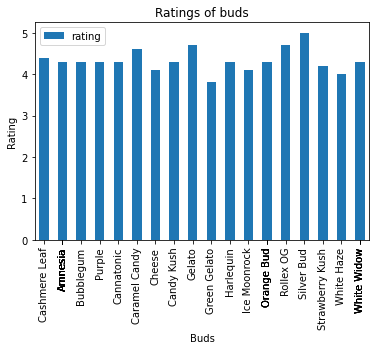

In [214]:
df = merging_shop_rating("Happy")

df.plot(kind="bar", x="product", y="rating")
plt.title("Ratings of buds")
plt.xlabel("Buds")
plt.ylabel("Rating")

In [170]:
shop_ratings("Happy")

,product,rating
0,Cashmere Leaf,4.4
1,Amnesia,4.3
2,Amnesia,4.3
3,Amnesia,4.3
4,Bubblegum,4.3
5,Purple,4.3
6,Cannatonic,4.3
7,Caramel Candy,4.6
8,Cheese,4.1
9,Candy Kush,4.3


In [158]:
rs = db.cbd_ratings.aggregate([{ "$group" : { "_id":0, "max": { "$max" : "$rating" }}}])

In [159]:
list(rs)

[{'_id': 0, 'max': 5.0}]

In [82]:
""" STACKOVERFLOW:
def findmood():
    
db.users.aggregate([{$lookup:
  {
        from: "contacts",
        localField: "number",
        foreignField: "phonenumber",
        as: "same"
    }
   },
   {
      $match: { "same": { $ne: [] } }
   }
])

"""

' STACKOVERFLOW:\ndef findmood():\n    \ndb.users.aggregate([{$lookup:\n  {\n        from: "contacts",\n        localField: "number",\n        foreignField: "phonenumber",\n        as: "same"\n    }\n   },\n   {\n      $match: { "same": { $ne: [] } }\n   }\n])\n\n'